In [ ]:
# stats
!pip install kneed
!pip install wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn import cluster, svm
import matplotlib.pyplot as plt
from kneed import KneeLocator
from tqdm import tqdm


# support
from collections import Counter
from itertools import chain
from os.path import exists
from datetime import date
from datetime import datetime

# text preprocessing
import string
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import spacy
nlp = spacy.load('en_core_web_sm')


# LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim import corpora, models
from gensim.models import Phrases
from gensim.corpora import Dictionary

# bert topics
!pip install bertopic
from bertopic import BERTopic

#Sentiment Analysis
# from textblob import TextBlob
!pip install nltk
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns


# Please uncomment this to run the code in google colab
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/CriticalDataMedia/Research_assignment2/data/'

# Comment this if its run on google colab
#path = "data\Data Assignment 1 Take Home Exam\\" # path for local running

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Basic Analysis

In [ ]:
ftx = pd.read_csv(path + 'ftx_final.csv')
ftx.head()

,Date,Tweet,Username,Likes,Users Followers,Users id,Tweet quote,Tweet replies,Tweet retweets
0,2022-09-01 23:59:36+00:00,Ex CFTC Commissioner Joins FTX US Derivatives ...,mindfrozentime,0.0,913.0,1.565490e+18,0.0,0.0,0.0
1,2022-09-01 23:59:17+00:00,Market buying drive coming from FTX Market (sp...,52kskew,75.0,51948.0,1.565490e+18,0.0,6.0,3.0
2,2022-09-01 23:58:32+00:00,Buy YoStep Sneakers on YoBit and Earn $$$! Hur...,ArturoLoay,0.0,55.0,1.565490e+18,0.0,0.0,0.0
3,2022-09-01 23:56:31+00:00,"@52kskew If FTX bidding, that means they are i...",exitpumpBTC,2.0,4041.0,1.565490e+18,0.0,3.0,0.0
4,2022-09-01 23:55:08+00:00,"📈💶$1,474,378 $BTC LONGED @$20152.0 [01/09/22 2...",WhaleTrades,4.0,188633.0,1.565490e+18,0.0,0.0,1.0


In [ ]:
#Convert the Date column from string object to datetime and handle the non-matching input(errors= 'coerce') will set NaT (not a time) value.
#From the datetime keep only the date with dt.date

ftx['Date'] = pd.to_datetime(ftx['Date'], format='%Y-%m-%d', errors='coerce')
 #https://www.w3schools.com/python/python_datetime.asp

In [ ]:
ftx.dropna(inplace=True)

In [ ]:
print(ftx['Tweet'].shape)
# there are 1180 retweets
ftx['Tweet'].str.contains('RT').sum()

(40740,)


1180

# Functions for preprocessing

In [ ]:
# basic preprocessing for every text mining task
# I will use this function most of the time cause this is the bare minimum for any text mining task. It makes the text consistent and clean
# I won't use this function in some cases since digits could be important
def preprocess(to_clean):
    to_clean = to_clean.astype(str)
    to_clean = to_clean.str.lower() #lowercase
    to_clean = to_clean.str.translate(str.maketrans(' ', ' ', string.digits)) # remove digits
    to_clean = to_clean.str.translate(str.maketrans(' ', ' ', string.punctuation)) # remove punctuation
    to_clean = to_clean.str.strip() # remove whitespace
    to_clean = [re.sub(r'([^\w\s]|_|@|;)','', str(x)) for x in to_clean] # remove symbols
    to_clean = [re.sub(r'http\S+','', str(x)) for x in to_clean] # #remove URLs
    #removing non-ascii characters 
    to_clean = [re.sub(r'[^\x00-\x7F]+', '', str(x)) for x in to_clean]
    return(to_clean)

In [ ]:
# function to include certain pos taggings
def include_features(x, tags=['VERB', 'PROPN', 'NOUN', 'ADJ']):
    include_features = tags #see the table below for explaination of tags, try with different combinations
    text = ' '.join([ent.text for ent in x if ent.pos_ in include_features])
    return text

# Functions for analysis

In [ ]:
def top(df_top, col):
    # first I remove every post without any adjectives than I make a list of all the adjectives, however this is a nested list since one post can have more than 1 adjective
    nested_list = list(df_top.loc[df_top[col] != '', col].apply(lambda x: x.split()))
    # to unnest the list I use chain from itertools and make it a list again
    # After that I use Counter from collections which makes a dictionary that counts the occurance of every unique adjective than I sort this dictionary by the keys and select the top 20
    top = sorted(Counter(list(chain(*nested_list))).items(), key=lambda x:x[1], reverse=True)

    #the 20 most used adjectives in comments per show, code below:
    if top == []:
        top = ['empty this year']
    return(top)

In [ ]:
# knee locater
def knee_loc(tf_idf, K=range(1,20)):
    OMP_NUM_THREADS=8
    inertia = []
    sse = {}

    for k in tqdm(K): #calculate sse per cluster thats in range K
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tf_idf)
        sse[k] = kmeans.inertia_ # save sse for visualisation
        inertia.append(kmeans.inertia_) # save sse for suggested amount of topics (knee/elbow)

    # Plot SSE and compute the amount of clusters    
    plt.title('knee plot for K selection')
    plt.xlabel('k')
    plt.ylabel('SSE')
    sns.pointplot(x=list(sse.keys()),
                    y=list(sse.values()))
    plt.show()

    kn = KneeLocator(K, inertia, curve='convex', direction='decreasing')
    print('knee =', kn.knee)
    return kn

In [ ]:
# use kn.knee clusters and assign the centers to the documents
# Top words per cluster (15, adjust as needed)
def kmeans_topics(tf_idf, k, n_topics=15):
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means.fit(tf_idf)
    order_centroids = k_means.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    dict = []
    cluster_size = sorted(Counter(k_means.labels_).items())
    for i in tqdm(range(k)):
        print(cluster_size[i], sep='', end=','),
        for ind in order_centroids[i, :n_topics]: # 15 words per topic
            print(terms[ind], sep='', end=',')
        print('')
    return k_means

In [ ]:
# With this function I can extract some tweets from the given model and the predicted topic
def tweets(df_tweet, model, n=3):
    for i in range(0,model.labels_.max()+1): # for every topic give me some tweets
        print('Topic', int(i)+1, '\n', df_tweet.loc[model.labels_==i, 'Tweet'].sample(frac=1).values[:n]) # topic number + 3 random tweets from that topic

In [ ]:
# answer to question 2.2 using Topic modelling
# https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
def topics(text, n_topics, tf_idf=False):
    processed_docs = text.apply(lambda x:word_tokenize(x)) # tokenize
    dictionary = gensim.corpora.Dictionary(processed_docs) # make dictionary for all the words (words converted to ids)
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=None) # pruning dictionary to reduce noise
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs] # For each document we create a dictionary reporting how many words and how many times those words appear
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    if tf_idf==False:
        # lda model using bag of words
        lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=n_topics, id2word=dictionary, passes=2, workers=2)
        print('bow topics:')
        for idx, topic in lda_model.print_topics(-1):
            print('Topic: {} Words: {}'.format(idx, topic))

        return lda_model
    else:
        # lda model using tfidf
        print('tfidf_topics:')
        lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=n_topics, id2word=dictionary, passes=2, workers=4)
        for idx, topic in lda_model_tfidf.print_topics(-1):
            print('Topic: {} Words: {}'.format(idx, topic))
        return lda_model_tfidf
        

# Preprocessing

In [ ]:
if not exists(path+'PBS_reddit.csv'): # check if preprocessed file already exists.

    # Basic preprocessing
    df_ftx = ftx.copy()
    df_ftx['clean_text'] = preprocess(df_ftx['Tweet'])
    df_ftx['tokens'] = df_ftx['clean_text'].apply(lambda x:nlp(x))
    df_ftx['clean_text'] = df_ftx['tokens'].apply(lambda x: include_features(x)) # keep certain POS tags

    # remove stopwords
    stop_words = stopwords.words('english')
    new_stopwords = ['rt', 'ヅ'] # in twitter rt means retweet which is not usefull informatie for our purposes
    stop_words.extend(new_stopwords)
    df_ftx['clean_text'] = df_ftx['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

    # lemmatization and pass string back
    df_ftx['clean_text_lemma'] = [lemmatizer.lemmatize(w) for w in df_ftx['clean_text'].astype(str)]  
    df_ftx['clean_text'].dropna(inplace=True) # drop empty rows
    df_ftx['clean_text_lemma'].dropna(inplace=True)
    df_ftx.to_csv(path+'clean_tweets.csv') # save as csv
    
else: # if file exists than load it from folder
    df_ftx = pd.read_csv(path+'clean_tweets.csv', index_col=0)

In [ ]:
print(df_ftx.shape)
df_ftx.head()

(54223, 12)


,Date,Tweet,Username,Likes,Users Followers,Users id,Tweet quote,Tweet replies,Tweet retweets,clean_text,tokens,clean_text_lemma
0,2022-09-01 23:59:36+00:00,Ex CFTC Commissioner Joins FTX US Derivatives ...,mindfrozentime,0.0,913.0,1.565490e+18,0.0,0.0,0.0,ex cftc commissioner joins us derivatives board,ex cftc commissioner joins ftx us derivatives ...,ex cftc commissioner joins us derivatives board
1,2022-09-01 23:59:17+00:00,Market buying drive coming from FTX Market (sp...,52kskew,75.0,51948.0,1.565490e+18,0.0,6.0,3.0,market buying drive coming ftx market spot amp...,market buying drive coming from ftx market spo...,market buying drive coming ftx market spot amp...
2,2022-09-01 23:58:32+00:00,Buy YoStep Sneakers on YoBit and Earn $$$! Hur...,ArturoLoay,0.0,55.0,1.565490e+18,0.0,0.0,0.0,buy yostep sneakers yobit earn hurry buy yoste...,buy yostep sneakers on yobit and earn hurry t...,buy yostep sneakers yobit earn hurry buy yoste...
3,2022-09-01 23:56:31+00:00,"@52kskew If FTX bidding, that means they are i...",exitpumpBTC,2.0,4041.0,1.565490e+18,0.0,3.0,0.0,kskew ftx bidding means interested protecting ...,kskew if ftx bidding that means they are inter...,kskew ftx bidding means interested protecting ...
4,2022-09-01 23:55:08+00:00,"📈💶$1,474,378 $BTC LONGED @$20152.0 [01/09/22 2...",WhaleTrades,4.0,188633.0,1.565490e+18,0.0,0.0,1.0,btc longed ftx btcperp satoshi craig wright zorn,btc longed \nftx btcperp\n\nwe are all sat...,btc longed ftx btcperp satoshi craig wright zorn


# Basic analysis

In [ ]:
# there are 1180 retweets
df_ftx['Tweet'].str.contains('RT').sum()

1180

In [ ]:
#Convert the Date column from string object to datetime and handle the non-matching input(errors= 'coerce') will set NaT (not a time) value.
#From the datetime keep only the date with dt.date

df_ftx['Date'] = pd.to_datetime(df_ftx['Date'], format='%Y-%m-%d', errors='coerce')
 #https://www.w3schools.com/python/python_datetime.asp

In [ ]:
df_ftx.dropna(inplace=True)

In [ ]:
len(df_ftx)

40733

In [ ]:
# The data is only tweets from 29th of october till the 6th of december
print(df_ftx.Date.min(), df_ftx.Date.max())

2022-09-01 21:16:15+00:00 2022-12-31 23:59:57+00:00


In [ ]:
# top adjectives
df_ftx['tokens'] = df_ftx['clean_text'].apply(lambda x:nlp(x))
df_ftx['adj'] = df_ftx['tokens'].apply(lambda x: include_features(x, ['ADJ']))
top(df_ftx, 'adj')[:10]

[('top', 2813),
 ('ftxofficial', 2306),
 ('skewed', 2277),
 ('bullish', 1980),
 ('last', 1247),
 ('large', 1234),
 ('average', 1143),
 ('new', 1012),
 ('good', 681),
 ('abnormal', 582)]

In [ ]:
adj_text = df_ftx['adj'].str.cat(sep = ' ')
adj_text

' bitfinex  interested bullish  tight average skewed  sorry stupid  btcperp  average average top last  top bullish perp matic top bullish average average ftxofficial  top bullish perp matic top bullish   skewed skewed skewed mainstream   top bullish bal top bullish average average average average average average  top bottom full jamie   top bullish bal top bullish ftxofficial skewed average average former  average average average average worthy average skewed average skewed skewed big  first much open short many short   top bullish top bullish average average average average average average highfive new  top bullish top bullish skewed former    uniswap btcperp average average average average liem many    top bullish bal top bullish tsla  nice short top bullish bal top bullish tsla emoji short long latest large turkish  good long short average average abnormal abnormal abnormal abnormal abnormal abnormal average average average skewed usdtusd skewed average average average average avera

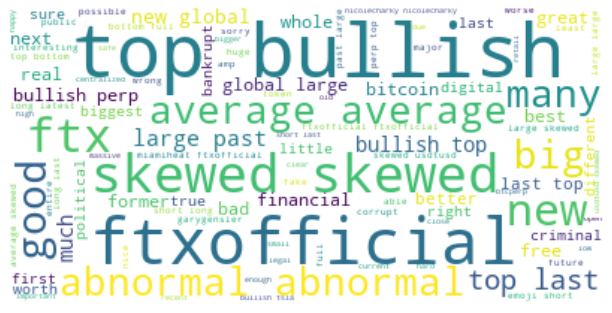

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(adj_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We see from the above wordcloud that most popular adjectives used in tweeter discussions are: top, bullish, skewed, abnormal and others. Less used ones are: big, good, many, new, large among others. 

In [ ]:
# top nouns
df_ftx['noun'] = df_ftx['tokens'].apply(lambda x: include_features(x, ['NOUN']))
top(df_ftx, 'noun')[:10]

[('ftx', 9954),
 ('volume', 6992),
 ('price', 5269),
 ('impact', 3669),
 ('money', 2509),
 ('results', 2316),
 ('mins', 2305),
 ('buy', 2126),
 ('sell', 2066),
 ('trends', 1884)]

In [ ]:
noun_text = df_ftx['noun'].str.cat(sep = ' ')
noun_text

'derivatives board market buying drive ftx market spot amp perp market spot amp perp binance market futures amp spot sneakers yobit earn hurry shib bidding lows  stoploss risk management cryptgold volume price impact volume volume cadusd ftx sell volume mins price impact btcperp sir family martinbuchwald show ftx buying bitfines mms btcethendgamer gencersancar market aggro bid books volume maticbullusd price impact volume volume maticbullusd price impact volume coins hour comp ceo winter bailout results results trends pair atom trends usd pair spy ftx results signals dyor volume ftx price impact volume volume ftx price impact volume  ftx baby results trends pair atom trends usd pair spy ftx results signals dyor  bingxlatino volume buy fttusd buy volume mins price impact volume buy volume mins price impact volume buy buy volume mins price impact push ftx binance advertise businesses money son  results trends perp pair prom op trends usd pair mrna uber spy results signals dyor volume pri

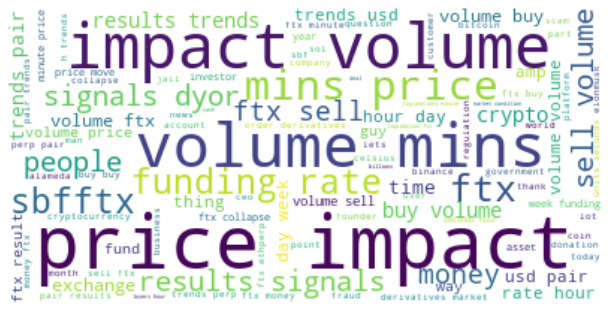

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(noun_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

From the above wordcloud we can distinguish the following most popular nouns: impact, volume, price, ftx. Less commonly used are nouns such as: exchange, crypto, sell, people, results among others. 

**Note** that the wordclouds were not included in our report since there was not enough space.

# Basic topic modelling with kmeans

In [ ]:
#answer to question 2.2 using Kmeans
#Vectorization tf_idf - check the documentation for how to use it: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer(min_df=20, max_df=0.4) #min_df max_df can be float or int I chose these values to reduce the amount of words since these are really big datasets

X = vectorizer.fit_transform(df_ftx['clean_text_lemma'])
tf_idf_ftx = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())
tf_idf_ftx.head()

,aarondbennett,aaukf,aave,aaveperp,ability,able,abnb,abnormal,absolute,ac,...,zachhodlon,zachxbt,zec,zelensky,zerohedge,zhusu,zil,zilliqa,zm,zrx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 9/9 [08:43<00:00, 58.17s/it]


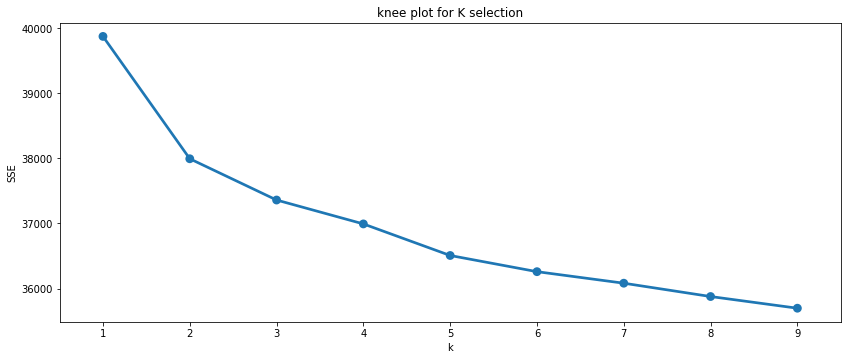

knee = 3


In [ ]:
# Knee gives 3
knee = knee_loc(tf_idf_ftx, range(1,10))

In [ ]:
model_knee_ftx = kmeans_topics(tf_idf_ftx, 3)

100%|██████████| 3/3 [00:00<00:00, 2331.46it/s]

(0, 36094),sbfftx,crypto,ftxofficial,binance,btc,money,sam,eth,funding,rate,bankmanfried,large,bitcoin,price,sbf,
(1, 1277),results,trends,pair,bullish,top,perp,dyor,signals,buy,usd,bito,gbtc,leo,abnb,chz,
(2, 3362),volume,impact,sell,price,buy,skewed,mismatch,mins,past,average,usdtusd,signal,whale,btc,btcusdt,


In [ ]:
tweets(posts, model_knee_ftx, 5)

Topic 1 
 ['@SenatorRomney Mitt Romney corrupt rhino are you going to pay back the FTX money that was stolen ! And you voted yourself a raise in the $1.7 trillion democrat spending spree to illegals and Ukraine you dirty dog'
 '🔝 Top gainers of the last hour (Out of Top 500) 📈\n\n🥇 #WING $11.3771 📈 9.09052768% \n🥈 #ERG $4.4786 📈 2.97056139% \n🥉 #BOND $6.7152 📈 2.94456821% \n4️⃣  #CEL $1.4889 📈 2.71543916% \n5️⃣  #MINA $0.6719 📈 1.84332705%\n\nTrade #crypto on FTX https://t.co/mYiDBXeBmw'
 'More FTX Fallout as Traders Turn Defensive - \n\nhttps://t.co/z1GbMI3Kxu\n\n#Crypto #CryptoNews #CryptoTrends #NFT #NFTNews #NFTRelease #NFTDrop #AltCoin #AirDrop #NFTProject #NFTArtist  #NFTCommunity  #CNFT #CNFTCommunnity'
 'Bitcoin, Binance Coin, FTX Token, and Stellar Daily Price Analyses – 11 September Morning Price Prediction - https://t.co/2A4POac6tx https://t.co/EUoaJShJHu'
 'b/w blue checks and FTX - oy vey,  how r we up 250 handles?']
Topic 2 
 ['[Scan results - #FTX - 1h]\n\nTop 5 bullish 

5 topics

In [ ]:
model_knee_ftx = kmeans_topics(tf_idf_ftx, 5)

100%|██████████| 5/5 [00:00<00:00, 3123.55it/s]

(0, 1277),results,trends,pair,bullish,top,perp,dyor,signals,buy,usd,bito,gbtc,leo,abnb,chz,
(1, 7061),sbfftx,bitboycrypto,ftxofficial,repmaxinewaters,czbinance,erikvoorhees,petermccormack,cdaggga,good,get,fadedpolo,nicolecharky,andrewrsorkin,elonmusk,people,
(2, 3362),volume,impact,sell,price,buy,skewed,mismatch,mins,past,average,usdtusd,signal,whale,btc,btcusdt,
(3, 849),funding,rate,abnormal,spotted,week,day,hour,lending,year,usd,eth,btc,rates,update,bottom,
(4, 28184),crypto,ftxofficial,binance,money,btc,sam,eth,bankmanfried,large,bitcoin,price,market,last,ethperp,sbf,


In [ ]:
tweets(df_ftx, model_knee_ftx, 5)

Topic 1 
 ['[Scan results - #FTX - 1h]\n\nTop 5 bullish trends on $PERP pair\n1: $BNB\n2: $SUSHI\n3: $THETA\n4: $BAND\n5: $FTT\n\nTop 5 bullish trends on $USD pair\n1: $NVDA\n2: $SPY\n3: $ETHE\n4: $AAPL\n5: $PENN\n\nAll FTX results: https://t.co/YlMcYQ5fFn\nNot buy signals. #DYOR'
 '[Scan results - #FTX - 15m]\n\nTop 5 bullish trends on $PERP pair\n1: $CEL\n2: $MATIC\n3: $BAL\n4: $DOGE\n5: $XMR\n\nTop 5 bullish trends on $USD pair\n1: $FB\n2: $AAPL\n3: $MRNA\n4: $NFLX\n5: $UBER\n\nAll FTX results: https://t.co/ypxjbS79IW\nNot buy signals. #DYOR'
 '[Scan results - #FTX - 15m]\n\nTop 5 bullish trends on $PERP pair\n1: $XTZ\n2: $XMR\n3: $ZRX\n4: $SXP\n5: $STORJ\n\nTop 5 bullish trends on $USD pair\n1: $ABNB\n2: $UBER\n3: $BITO\n4: $SPY\n5: $APHA\n\nAll FTX results: https://t.co/ypxjbS7Hyu\nNot buy signals. #DYOR'
 '[Scan results - #FTX - 15m]\n\nTop 5 bullish trends on $PERP pair\n1: $REEF\n2: $HBAR\n3: $FTT\n4: $NEAR\n5: $ICX\n\nAll FTX results: https://t.co/kFG8XpNRPZ\nNot buy signals. 

# LDA Topic Modelling

In [ ]:
# bag of word topics
lda_ftx = topics(df_ftx['clean_text_lemma'], n_topics=5)

bow topics:
Topic: 0 Words: 0.050*"sbfftx" + 0.024*"sam" + 0.022*"bankmanfried" + 0.020*"crypto" + 0.011*"sbf" + 0.009*"ceo" + 0.008*"bitboycrypto" + 0.008*"ftxofficial" + 0.007*"alameda" + 0.007*"exchange"
Topic: 1 Words: 0.051*"top" + 0.038*"results" + 0.032*"bullish" + 0.030*"pair" + 0.027*"trends" + 0.025*"buy" + 0.020*"perp" + 0.019*"dyor" + 0.019*"signals" + 0.017*"k"
Topic: 2 Words: 0.031*"sbfftx" + 0.021*"crypto" + 0.018*"money" + 0.012*"collapse" + 0.011*"funds" + 0.007*"binance" + 0.007*"know" + 0.007*"people" + 0.006*"sbf" + 0.006*"ftxofficial"
Topic: 3 Words: 0.025*"sbfftx" + 0.022*"crypto" + 0.019*"money" + 0.013*"btc" + 0.012*"ukraine" + 0.011*"market" + 0.010*"see" + 0.010*"democrats" + 0.010*"new" + 0.008*"laundering"
Topic: 4 Words: 0.102*"volume" + 0.073*"price" + 0.056*"impact" + 0.055*"sell" + 0.052*"buy" + 0.042*"past" + 0.035*"mins" + 0.034*"mismatch" + 0.033*"skewed" + 0.022*"letting"


# Topic Modelling over the years/months

In [ ]:
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(df_ftx['clean_text_lemma'].to_list())

Batches:   0%|          | 0/1273 [00:00<?, ?it/s]

2023-02-03 16:05:45,204 - BERTopic - Transformed documents to Embeddings
2023-02-03 16:07:15,235 - BERTopic - Reduced dimensionality
2023-02-03 16:07:22,574 - BERTopic - Clustered reduced embeddings


In [ ]:
topic_model.visualize_barchart(top_n_topics=10)

In [ ]:
#topic_model.visualize_topics()

In [ ]:
topics_over_time = topic_model.topics_over_time(df_ftx["clean_text_lemma"].to_list(), df_ftx.Date.to_list(), nr_bins=10)

10it [00:10,  1.03s/it]


In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[0,1,2,3,4])

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[5,6,7,8,9])

# Sentiment over years/months

In [ ]:
#Preprocessing the tweets for sentiment analysis by keeping the emojis but not applying lemmatization
def preprocess_sentiment(to_clean):
    to_clean = to_clean.astype(str)
    to_clean = to_clean.str.lower() #lowercase
    to_clean = to_clean.str.translate(str.maketrans(' ', ' ', string.digits)) # remove digits
    to_clean = to_clean.str.translate(str.maketrans(' ', ' ', string.punctuation)) # remove punctuation
    to_clean = to_clean.str.strip() # remove whitespace
    to_clean = [re.sub(r'([^\w\s\U0001f600-\U0001f650]|_|@|;)','', str(x)) for x in to_clean] # remove non-word characters(e.g. symbols) keep emojis
    to_clean = [re.sub(r'http\S+','', str(x)) for x in to_clean] # #remove URLs
    
    return(to_clean)

In [ ]:
# function to include certain pos taggings
def include_features(x, tags=['VERB', 'PROPN', 'NOUN', 'ADJ']):
    include_features = tags #see the table below for explaination of tags, try with different combinations
    text = ' '.join([ent.text for ent in x if ent.pos_ in include_features])
    return text

In [ ]:
# if not exists(path+'clean_tweets.csv'): # check if preprocessed file already exists.
if not exists('clean_tweets.csv'): # check if preprocessed file already exists.

    # Basic preprocessing
    df_ftx = ftx.copy()
    df_ftx['clean_text'] = preprocess_sentiment(df_ftx['Tweet'])
    df_ftx['tokens'] = df_ftx['clean_text'].apply(lambda x:nlp(x))
    df_ftx['clean_text'] = df_ftx['tokens'].apply(lambda x: include_features(x)) # keep certain POS tags

    # remove stopwords
    stop_words = stopwords.words('english')
    new_stopwords = ['rt', 'ヅ'] # in twitter rt means retweet which is not usefull informatie for our purposes
    stop_words.extend(new_stopwords)
    df_ftx['clean_text'] = df_ftx['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    df_ftx['clean_text'].dropna(inplace=True) # drop empty rows
    # df_ftx.to_csv(path+'clean_tweets.csv') # save as csv
    df_ftx.to_csv('clean_tweets.csv') # save as csv
    
else: # if file exists than load it from folder
    # df_ftx = pd.read_csv(path+'clean_tweets.csv', index_col=0)
    df_ftx = pd.read_csv('clean_tweets.csv', index_col=0)

In [ ]:
len(df_ftx)

40740

In [ ]:
df_ftx['Date'] = pd.to_datetime(df_ftx['Date'], format='%Y-%m-%d', errors='coerce')


In [ ]:
df_ftx.dropna(inplace=True)

In [ ]:
len(df_ftx)

40734

In [ ]:
print(df_ftx.shape)
df_ftx.head()

(40734, 11)


,Date,Tweet,Username,Likes,Users Followers,Users id,Tweet quote,Tweet replies,Tweet retweets,clean_text,tokens
0,2022-09-01 23:59:36+00:00,Ex CFTC Commissioner Joins FTX US Derivatives ...,mindfrozentime,0.0,913.0,1.565490e+18,0.0,0.0,0.0,ex cftc commissioner joins us derivatives board,ex cftc commissioner joins ftx us derivatives ...
1,2022-09-01 23:59:17+00:00,Market buying drive coming from FTX Market (sp...,52kskew,75.0,51948.0,1.565490e+18,0.0,6.0,3.0,market buying drive coming ftx market spot amp...,market buying drive coming from ftx market spo...
2,2022-09-01 23:58:32+00:00,Buy YoStep Sneakers on YoBit and Earn $$$! Hur...,ArturoLoay,0.0,55.0,1.565490e+18,0.0,0.0,0.0,buy yostep sneakers yobit earn hurry buy yoste...,buy yostep sneakers on yobit and earn hurry t...
3,2022-09-01 23:56:31+00:00,"@52kskew If FTX bidding, that means they are i...",exitpumpBTC,2.0,4041.0,1.565490e+18,0.0,3.0,0.0,kskew ftx bidding means interested protecting ...,kskew if ftx bidding that means they are inter...
4,2022-09-01 23:55:08+00:00,"📈💶$1,474,378 $BTC LONGED @$20152.0 [01/09/22 2...",WhaleTrades,4.0,188633.0,1.565490e+18,0.0,0.0,1.0,btc longed ftx btcperp satoshi craig wright zorn,btc longed \nftx btcperp\n\nwe are all sat...


In [ ]:
#create new dataframe by selecting the columns you are interested for
df_ftx_sent = df_ftx[['clean_text', 'Date']].copy()

In [ ]:
#Because dt.date convert it to string object we need to reconvert it to datetime
df_ftx_sent['Date'] = pd.to_datetime(df_ftx_sent['Date'], format='%Y-%m-%d').dt.date
df_ftx_sent['Date']

0        2022-09-01
1        2022-09-01
2        2022-09-01
3        2022-09-01
4        2022-09-01
            ...    
40747    2022-12-31
40748    2022-12-31
40749    2022-12-31
40750    2022-12-31
40751    2022-12-31
Name: Date, Length: 40734, dtype: object

In [ ]:
df_ftx_sent['Date'] = pd.to_datetime(df_ftx_sent['Date'], format='%Y-%m-%d')
df_ftx_sent['Date']

0       2022-09-01
1       2022-09-01
2       2022-09-01
3       2022-09-01
4       2022-09-01
           ...    
40747   2022-12-31
40748   2022-12-31
40749   2022-12-31
40750   2022-12-31
40751   2022-12-31
Name: Date, Length: 40734, dtype: datetime64[ns]

In [ ]:
#Sentiment analysis with VADER lexicon which is optimized to analyze social media text and its able to handle the complexities of social media language.
#The result generated by VADER is a dictionary of 4 keys neg, neu, pos and compound: 
#compound corresponds to the sum of the valence score of each word in the lexicon and determines the degree of the sentiment rather than the actual value as opposed to the previous ones. 

negative_sent = "I do HATE those fake news on internet !!😡"
print(sent_analyzer.polarity_scores(negative_sent))

{'neg': 0.575, 'neu': 0.425, 'pos': 0.0, 'compound': -0.8449}


In [ ]:
#Extend Vader's lexicon by assigning some cryptoslang terms with each corresponding polarity value. 
mylist = {'fomo': -3.4,'fud': -3,'mooning': 3.5,'whales': -2.9,
          'pump': -3.3,'dump': -3.2, 'rekt': -2.3, 'bullish':1.3,
          'bearish':-1.3,'ath':3.6,'dyor':1.2, 'moon':3.5, 'shill':-3.3,
          'moonshot':2.2, 'lambo':-0.9, 'cold wallet':-2.9, 'bull run':2.8,
          'bear market': -2.8, 'airdrop': 1.4, 'hard fork': 0.9, 'bull trap': -3.4,
          'ngmi': -3.4, 'wagmi': 3.4,'normie': -2.3, 'rug pull': -3.3, 'weak hands': -2.9    
}

sent_analyzer.lexicon.update(mylist)

In [ ]:
#Create function to define the thresholds for negative, positive and negative polarity based on the compound sentiment of the vader lexicon
def vaderPolarity(output):

  polarity = "neutral"

  if(output["compound"] >=0.01):
        polarity = "positive"

  elif(output["compound"] <= -0.01):
      polarity = "negative"

  return polarity

#Create function to return the sentiment of a text
def predict_sentiment(text):
  
  output = sent_analyzer.polarity_scores(text)
  return vaderPolarity(output)

In [ ]:
#We need to drop some missing values again
df_ftx_sent.dropna(inplace=True)

In [ ]:
df_ftx_sent.head()

,clean_text,Date
0,ex cftc commissioner joins us derivatives board,2022-09-01
1,market buying drive coming ftx market spot amp...,2022-09-01
2,buy yostep sneakers yobit earn hurry buy yoste...,2022-09-01
3,kskew ftx bidding means interested protecting ...,2022-09-01
4,btc longed ftx btcperp satoshi craig wright zorn,2022-09-01


In [ ]:
df_ftx_sent["Vader_sentiment"] = df_ftx_sent["clean_text"].apply(predict_sentiment)

In [ ]:
df_ftx_sent.dtypes

clean_text                 object
Date               datetime64[ns]
Vader_sentiment            object
dtype: object

In [ ]:
# df_ftx_sent.to_csv('/content/drive/MyDrive/ADS/Critical Data Mining of Media Culture - Copy/Weeks/ftx_sentiment_thanos.csv')
df_ftx_sent.to_csv(path + 'ftx_sentiment.csv')

# df_ftx_sent = pd.read_csv(path + 'ftx_final.csv')
# df_ftx_sent.head()

In [ ]:
df_ftx_sent.head()

,clean_text,Date,Vader_sentiment
0,ex cftc commissioner joins us derivatives board,2022-09-01,neutral
1,market buying drive coming ftx market spot amp...,2022-09-01,neutral
2,buy yostep sneakers yobit earn hurry buy yoste...,2022-09-01,neutral
3,kskew ftx bidding means interested protecting ...,2022-09-01,positive
4,btc longed ftx btcperp satoshi craig wright zorn,2022-09-01,neutral


In [ ]:
 df_ftx_sent['Date'] = pd.to_datetime(df_ftx_sent['Date'], format='%Y-%m-%d', errors='coerce')

In [ ]:
#Calculate the number of occurences of each sentiment for each day
df_ftx_sent['day'] = df_ftx_sent['Date'].dt.round('D')

aggregation = {'Counts_of_sentiments': ('Date', 'count')}
df_sentiment_by_day = df_ftx_sent.groupby(['Date', 'Vader_sentiment']).agg(**aggregation).reset_index()

df_sentiment_by_day

,Date,Vader_sentiment,Counts_of_sentiments
0,2022-09-01,negative,37
1,2022-09-01,neutral,229
2,2022-09-01,positive,67
3,2022-09-02,negative,44
4,2022-09-02,neutral,190
...,...,...,...
361,2022-12-30,neutral,95
362,2022-12-30,positive,121
363,2022-12-31,negative,157
364,2022-12-31,neutral,89


# Visualization of sentiments over time

In [ ]:
import plotly.express as px

fig = px.line(df_sentiment_by_day, x="Date", y="Counts_of_sentiments", color="Vader_sentiment")
fig.update_xaxes(title_text='Day | September - December 2022')
fig.update_yaxes(title_text='Count the sentiments for each day')
fig.show()

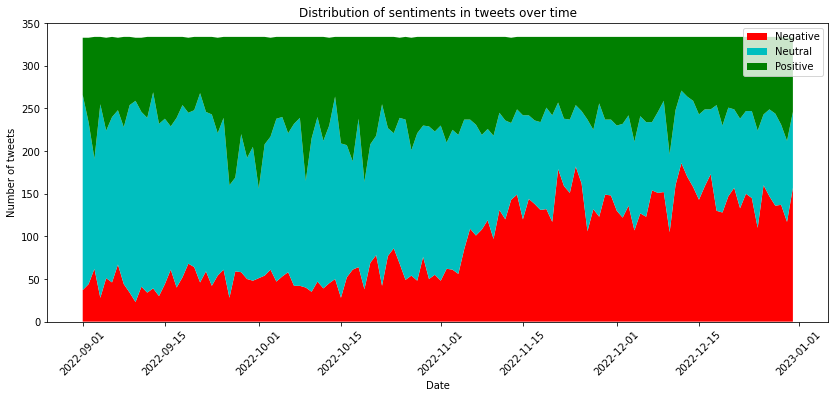

In [ ]:
# Stacked area plot for the sentiments over time
plt.rcParams["figure.figsize"] = (14,5.5)

plt.stackplot(df_sentiment_by_day["Date"].unique(),df_sentiment_by_day[df_sentiment_by_day["Vader_sentiment"]=='negative']["Counts_of_sentiments"], df_sentiment_by_day[df_sentiment_by_day["Vader_sentiment"]=='neutral']["Counts_of_sentiments"], df_sentiment_by_day[df_sentiment_by_day["Vader_sentiment"]=='positive']["Counts_of_sentiments"], labels=['Negative','Neutral','Positive'], colors=['r', 'c', 'g'])

plt.xlabel("Date")
plt.ylabel("Number of tweets")
plt.title("Distribution of sentiments in tweets over time")

plt.xticks(rotation = 45)
plt.legend()


# Link of the Sentiments Analysis with the cryptomarket

In [ ]:
# Load the data of the prices of Ethereum and Bitcoin
eth = pd.read_csv(path +'eth_daily.csv', index_col=0)
btc = pd.read_csv(path + 'btc_daily.csv', index_col=0)
eth.head()

,Date,Open,High,Low,Close
0,12/31/2022,"1,197.51","1,206.99","1,192.00","1,199.52"
1,12/30/2022,"1,195.20","1,203.03","1,183.27","1,197.20"
2,12/29/2022,"1,186.77","1,205.19","1,184.00","1,195.20"
3,12/28/2022,"1,210.29","1,213.92","1,184.36","1,186.77"
4,12/27/2022,"1,216.70","1,232.38","1,201.00","1,210.24"


In [ ]:
# Function to preprocess the data of the cryptomarket
def preprocess_prices(df):
    # String to float (we have to remove the ',' delimiting the thousands)
    df["Open"] = df["Open"].apply(lambda x: float(x.split()[0].replace(',', '')))
    df["High"] = df["High"].apply(lambda x: float(x.split()[0].replace(',', '')))
    df["Low"] = df["Low"].apply(lambda x: float(x.split()[0].replace(',', '')))
    df["Close"] = df["Close"].apply(lambda x: float(x.split()[0].replace(',', '')))

    # String to date
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by=["Date"])
    df = df.reset_index(drop=True)

    # Create daily variation column
    df["Variation"] = df["Open"] - df["Close"]

    # Column with the number of the week (we know we have data only from 2022, there won't be overlaps)
    df["Week"] = df["Date"].dt.isocalendar().week

    return df

In [ ]:
# Prepocess data of the cryptomarket
eth = preprocess_prices(eth)
btc = preprocess_prices(btc)
eth.head()

,Date,Open,High,Low,Close,Variation,Week
0,2022-09-01,1572.96,1584.20,1515.40,1580.77,-7.81,35
1,2022-09-02,1581.12,1648.92,1547.46,1568.51,12.61,35
2,2022-09-03,1571.78,1585.37,1536.11,1552.16,19.62,35
3,2022-09-04,1552.16,1582.87,1540.85,1571.36,-19.20,35
4,2022-09-05,1571.36,1609.82,1558.28,1598.42,-27.06,36


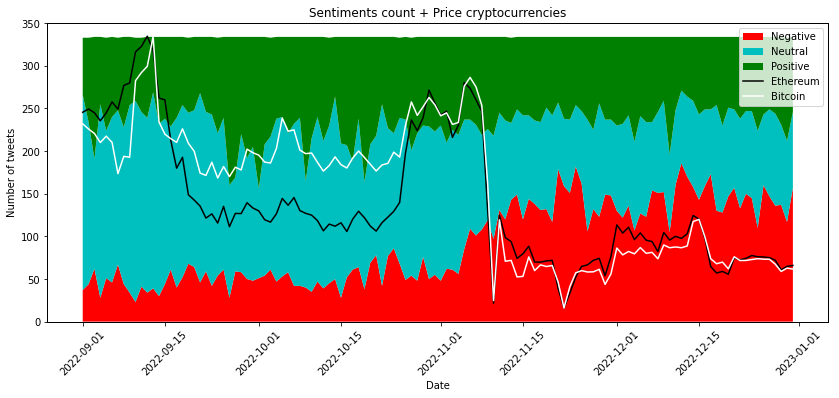

In [ ]:
# Stacked area plot for the sentiments and fluctuation of prices of cryptocurrencies over time
fig, ax1 = plt.subplots()
fig.set_size_inches(14, 5.5)

ax2 = ax1.twinx()
ax3 = ax1.twinx()

plot = ax1.stackplot(df_sentiment_by_day["Date"].unique(),df_sentiment_by_day[df_sentiment_by_day["Vader_sentiment"]=='negative']["Counts_of_sentiments"], df_sentiment_by_day[df_sentiment_by_day["Vader_sentiment"]=='neutral']["Counts_of_sentiments"], df_sentiment_by_day[df_sentiment_by_day["Vader_sentiment"]=='positive']["Counts_of_sentiments"], labels=['Negative','Neutral','Positive'], colors=['r', 'c', 'g'])
line1 = ax2.plot(eth["Date"], eth["Open"], color = 'k', label="Ethereum")
line2 = ax3.plot(btc["Date"], btc["Open"], color = 'w', label="Bitcoin")

ax2.grid(False)
ax3.grid(False)

ax2.axes.get_yaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)

plt.title("Sentiments count + Price cryptocurrencies")
ax1.set_xlabel("Date")
ax1.set_ylabel("Number of tweets")

lines = plot + line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0)
ax1.tick_params(axis='x', labelrotation = 45)
plt.show()